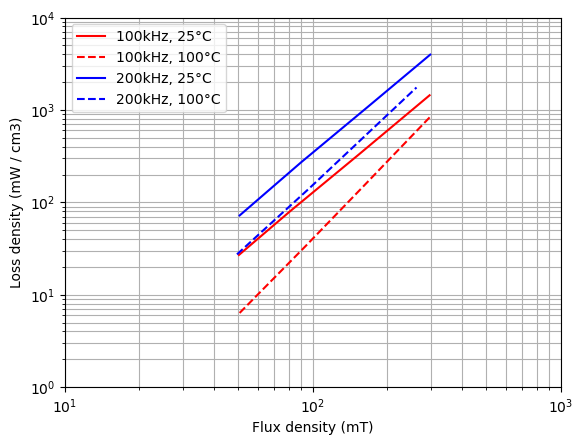

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# To remove or include
notebook_folder = os.getcwd()
df_100k_25C = pd.read_csv(notebook_folder + '/data/loss_magnetic_data_100k_25C.csv', header=0, names=['100k_25C_x', '100k_25C_y'])
df_100k_100C = pd.read_csv(notebook_folder + '/data/loss_magnetic_data_100k_100C.csv', header=0, names=['100k_100C_x', '100k_100C_y'])
df_200k_25C = pd.read_csv(notebook_folder + '/data/loss_magnetic_data_200k_25C.csv', header=0, names=['200k_25C_x', '200k_25C_y'])
df_200k_100C = pd.read_csv(notebook_folder + '/data/loss_magnetic_data_200k_100C.csv', header=0, names=['200k_100C_x', '200k_100C_y'])
df_Loss = pd.concat([df_100k_25C, df_100k_100C, df_200k_25C, df_200k_100C])

# Check Loss data for DMR44 magnetic material

# Data for 100 kHz and 25°C
data_100k_25C_x = [50.43988739093397, 81.06823664212065, 153.55415016812432, 296.20911241965206]
data_100k_25C_y = [26.941434246171102, 79.9673347137438, 329.4574652351894, 1440.70827878885]

# Data for 100 kHz and 100°C
data_100k_100C_x = [50.74767107013431, 93.24314401826693, 161.21209514454034, 296.20911241965206]
data_100k_100C_y = [6.3472995818200415, 33.19216637405551, 151.78532101352494, 830.0301178252122]

# Data for 200 kHz and 25°C
data_200k_25C_x = [50.74767107013431, 89.90107011797573, 166.19106151917026, 298.0165774071646]
data_200k_25C_y = [72.04522101505854, 271.429444531243, 1069.3656104673032, 3969.2230216707258]

# Data for 200 kHz and 100°C
data_200k_100C_x = [49.52769134960666, 96.70945957597505, 174.47922568335946, 262.2758216661127]
data_200k_100C_y = [27.345961868755982, 140.88582968667282, 625.3404255629255, 1748.7126295116889]

# Plot all these losses
plt.loglog(data_100k_25C_x, data_100k_25C_y, 'r', label = '100kHz, 25°C')
plt.loglog(data_100k_100C_x, data_100k_100C_y, 'r--', label = '100kHz, 100°C')
plt.loglog(data_200k_25C_x, data_200k_25C_y, 'b', label = '200kHz, 25°C')
plt.loglog(data_200k_100C_x, data_200k_100C_y, 'b--', label = '200kHz, 100°C')
plt.xlabel('Flux density (mT)')
plt.ylabel('Loss density (mW / cm3)')
plt.xlim(10, 1000)
plt.ylim(1, 1e4)
plt.grid(which='both')
plt.legend()

In [3]:
from scipy.interpolate import interp1d
 
def compute_loss_density(flux_density, frequency, temperature):

    # Create interpolators for each dataset
    interp_100k_25C = interp1d(data_100k_25C_x, data_100k_25C_y, kind='linear', fill_value='extrapolate')
    interp_100k_100C = interp1d(data_100k_100C_x, data_100k_100C_y, kind='linear', fill_value='extrapolate')
    interp_200k_25C = interp1d(data_200k_25C_x, data_200k_25C_y, kind='linear', fill_value='extrapolate')
    interp_200k_100C = interp1d(data_200k_100C_x, data_200k_100C_y, kind='linear', fill_value='extrapolate')
 
    # Compute losses for the given flux density from each interpolator
    y_100k_25C = interp_100k_25C(flux_density)
    y_100k_100C = interp_100k_100C(flux_density)
    y_200k_25C = interp_200k_25C(flux_density)
    y_200k_100C = interp_200k_100C(flux_density)
 
    # Interpolate over temperature for each frequency
    temperatures = [25, 100]
    y_100k_T = np.interp(temperature, temperatures, [y_100k_25C, y_100k_100C])
    y_200k_T = np.interp(temperature, temperatures, [y_200k_25C, y_200k_100C])
 
    # Interpolate over frequency
    frequencies = [100e3, 200e3]  # Frequencies in Hz
    y_f_T = np.interp(frequency, frequencies, [y_100k_T, y_200k_T])
 
    return y_f_T

In [4]:
flux_density = 100  # flux_density 100 mT
frequency = 150e3  # Frequency 150 kHz
temperature = 60  # Temperature 60°C
print(f"The interpolated loss density at:\n - B = {flux_density} mT,\n - frequency = {frequency} Hz,\n - temperature = {temperature}°C,\nis {compute_loss_density(flux_density, frequency, temperature)} mW / cm3")

The interpolated loss density at:
 - B = 100 mT,
 - frequency = 150000.0 Hz,
 - temperature = 60°C,
is 187.4013790541926 mW / cm3


In [5]:
# Compute transformer volume based on 2 E-core E64/18/50
base = 64 * 50 * 9 
legs = 2 * (18 * 50 * 9)                    # 1 central leg and 2 side legs equivalent to 2 central legs
single_ecore_volume = base + legs           # volume of 1 e-core (mm3)
core_volume = 2 * single_ecore_volume
# Compute equivalent magnetizing inductor
Ac = 0.000516                               # core section m²
Le = 0.112                                  # magnetic path length (m)
ur = 2400
uo = 4 * np.pi *1e-7
R = Le / Ac / (uo * ur)
Npri = 24
Lm = Npri**2 / R
print(f'Magnetizing inductor: {Lm * 1e3:.2f} mH')


Magnetizing inductor: 8.00 mH


Text(0.5, 0, 'time (ms)')

<Figure size 800x600 with 0 Axes>

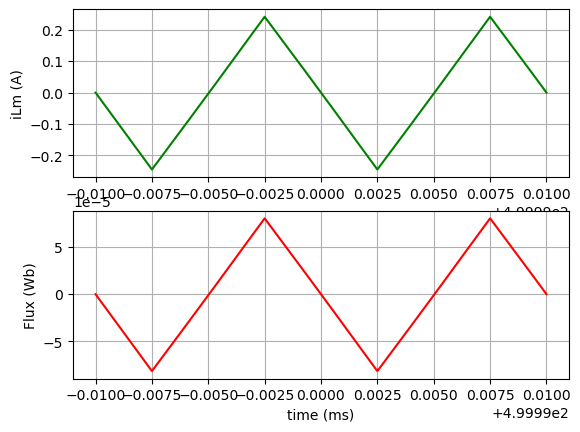

In [6]:
from aesim.simba import ProjectRepository

project = ProjectRepository(os.path.join(notebook_folder, 'dual_active_bridge_ti.jsimba'))
# design_mag = project.GetDesignByName('2- Magnetic Model')

design_elec = project.GetDesignByName('1- Electrical Model')
design_elec.Circuit.GetDeviceByName('Lm').Value = float(np.format_float_scientific(Lm, precision=3))
design_elec.TransientAnalysis.CompressScopes = True
design_elec.TransientAnalysis.TimeStep = 2e-9
design_elec.TransientAnalysis.EndTime = 0.5
job = design_elec.TransientAnalysis.NewJob()
status = job.Run()
if str(status) != "OK": 
    raise Exception(job.Summary())
signal_iLm = job.GetSignalByName('Lm - Current')
signal_vout = job.GetSignalByName('Vo - Out')

def steadystate_signal(horizon_time: float, *signals):
    timepoints_list = []
    for signal in signals:
        timepoints_list.extend(signal.TimePoints)
    timepoints = sorted(timepoints_list)
    steadystate_maskarray = np.array(timepoints) > (timepoints[-1] - horizon_time)
    steadystate_time = np.array(timepoints)[steadystate_maskarray]
    steadystate_datapoints_list = [np.interp(steadystate_time, signal.TimePoints, signal.DataPoints) for signal in signals]
    return steadystate_time, *steadystate_datapoints_list

fsw = design_elec.Circuit.GetDeviceByName('fsw').Value
time, vout, iLm = steadystate_signal(2 * 1 / fsw, signal_vout, signal_iLm)

flux = iLm * Lm / Npri
flux_density = flux / Ac

plt.figure(figsize=(8, 6))
fig = plt.figure()
plt.subplot(2, 1 , 1)
plt.plot(time*1e3, iLm, 'g')
plt.grid(True)
plt.ylabel('iLm (A)')
plt.subplot(2, 1, 2)
plt.plot(time*1e3, flux, 'r')
plt.grid(True)
plt.ylabel('Flux (Wb)')
plt.xlabel('time (ms)')
plt.tight_layout()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


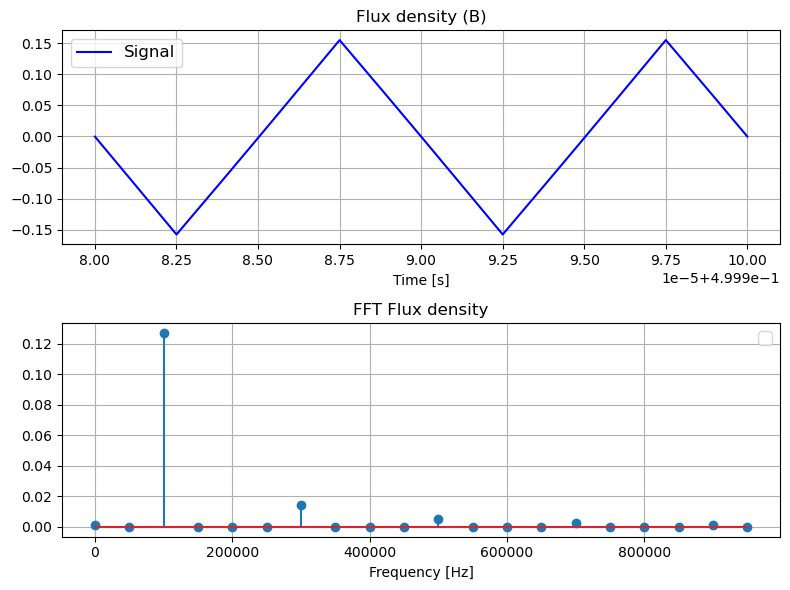

In [7]:
def compute_fft(time, signal, fstep):
    N = 10000
    time_resamp = np.linspace(time[0], time[-1], N, endpoint=False)
    signal_resamp = np.interp(time_resamp, time, signal)
    freqs = np.fft.rfftfreq(N) * fstep * len(signal_resamp)
    fft = np.abs(np.fft.rfft(signal_resamp) / len(signal_resamp))
    fft[1:] = 2 * fft[1:]
    return freqs, fft

freqs, fft_flux_density = compute_fft(time, flux_density, fsw/2)
max_index = 20
freqs = freqs[:max_index]
fft_flux_density = fft_flux_density[:max_index]

plt.figure(figsize=(8, 6))
# Plot the original signal
plt.subplot(2, 1, 1)
plt.plot(time, flux_density, color='blue', linestyle='-', linewidth=1.5, label='Signal')
plt.title('Flux density (B)')
plt.xlabel('Time [s]')
plt.grid(True)  # Add grid lines
plt.legend(fontsize=12)  # Add legend

plt.subplot(2, 1, 2)
plt.stem(freqs, fft_flux_density)
plt.title('FFT Flux density')
plt.xlabel('Frequency [Hz]')
plt.grid(True)  # Add grid lines
plt.legend(fontsize=12)  # Add legend

plt.tight_layout()
plt.show()

